In [ ]:
# These imports and declarations apply to all examples
import torch.nn as nn

import FrEIA.framework as Ff
import FrEIA.modules as Fm

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                        nn.Linear(512,  c_out))

def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

def subnet_conv_1x1(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 1))


 inn = Ff.SequenceINN(2)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

c:\Users\ext.saad.hussainshaf\FrEIA\FrEIA\modules\all_in_one_block.py:54: SyntaxWarning: invalid escape sequence '\m'
  '''


In [9]:
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from typing import Dict, List, Union, Tuple, Optional
from omegaconf import OmegaConf

## Data preparation

In [58]:
def drop_nan_inf(inputs: np.array) -> np.array:
    """
    Drop samples (axis > 0) with at least one nan or inf in one of the other dimensions.
    """
    nan_axis_inputs = tuple(range(1, inputs.ndim))
    nan_mask = np.isnan(inputs).any(axis=nan_axis_inputs) | np.isinf(inputs).any(axis=nan_axis_inputs)
    return inputs[~nan_mask]


def drop_matching_nan_inf(inputs: np.array, targets: np.array) -> np.array:
    """
    Drop samples (axis > 0) with at least one nan or inf between the other dimensions of the two arrays.
    """

    nan_axis_inputs = tuple(range(1, inputs.ndim))
    nan_axis_targets = tuple(range(1, targets.ndim))
    nan_mask = np.isnan(inputs).any(axis=nan_axis_inputs) | np.isinf(inputs).any(axis=nan_axis_inputs) | np.isnan(targets).any(axis=nan_axis_targets) | np.isinf(targets).any(axis=nan_axis_targets)
    inputs = inputs[~nan_mask]
    targets = targets[~nan_mask]

    return inputs, targets

In [59]:
def get_production_data(
    matched_data: Dict, 
    productions_df: pd.DataFrame, 
    hot_feats: List[str], 
    cold_feats: List[str],
    aggregation_func: str = 'mean',
    retrieve_meta: Optional[bool] = False
) -> Union[Tuple[np.array, np.array], Tuple[np.array, np.array, pd.DataFrame]]:
    """
    Given a subset of the matched production info dataframe, and the matched dataset, 
    it returns the stacked arrays of the corresponding input and output samples aggregated.
    Possible aggregations are: 'mean', 'mean_std', 'no_aggregation'
    """

    # Isolate samples with metadata matching with the requested productions
    metadata = pd.DataFrame(matched_data['meta'])
    N = len(metadata)
    prods_masks = []
    for _, row in productions_df.iterrows():
        prods_masks.append((metadata['start_hotend_window'].between(row.start_hotend.tz_localize(None), row.stop_hotend.tz_localize(None))) & (metadata['section_number']==row.section_number))
    test_mask = pd.concat(prods_masks, axis=1).any(axis=1).values
    metadata = metadata[test_mask].reset_index(drop=True)

    # Retrieve indices of the requested variables
    hot_cols_idxs = [matched_data['hot_columns'].index(x) for x in hot_feats]
    cold_cols_idxs = [matched_data['cold_columns'].index(x) for x in cold_feats]

    if aggregation_func == 'mean':
        
        hot_data = np.stack([np.nanmean(matched_data['hot'][i][:,hot_cols_idxs], axis=0) for i in range(N) if test_mask[i]])
        
        cold_data = np.stack([np.nanmean(matched_data['cold'][i][:,cold_cols_idxs], axis=0) for i in range(N) if test_mask[i]])
        hot_data = np.expand_dims(hot_data, axis=1)

        # Drop samples with nans or infs between hot and cold variables
        # hot_data shape = (training_samples, 32)
        # cold_data shape = (training_samples, 1)
        hot_data, cold_data = drop_matching_nan_inf(hot_data, cold_data)
    

    # usavo per probabilistic regression
    elif aggregation_func == 'mean_std':

        # here we do log-std for greater numerical stability
        hot_data_mean = np.stack([np.nanmean(matched_data['hot'][i][:,hot_cols_idxs], axis=0) for i in range(N) if test_mask[i]])
        hot_data_std = np.stack([np.log(np.nanstd(matched_data['hot'][i][:,hot_cols_idxs], axis=0)) for i in range(N) if test_mask[i]])
        hot_data = np.stack([hot_data_mean, hot_data_std], axis=1)
        cold_data_mean = np.stack([np.nanmean(matched_data['cold'][i][:,cold_cols_idxs], axis=0) for i in range(N) if test_mask[i]])
        cold_data_std = np.stack([np.log(np.nanstd(matched_data['cold'][i][:,cold_cols_idxs], axis=0)+1e-8) for i in range(N) if test_mask[i]])
        cold_data = np.stack([cold_data_mean, cold_data_std], axis=1).squeeze()

        hot_data, cold_data = drop_matching_nan_inf(hot_data, cold_data)

    elif aggregation_func == 'no_aggregation':

        # instead of returning aggregated samples we just return cleaned raw windows as lists
        hot_data = [drop_nan_inf(matched_data['hot'][i][:,hot_cols_idxs]) for i in range(N) if test_mask[i]]
        cold_data = [drop_nan_inf(matched_data['cold'][i][:,cold_cols_idxs]) for i in range(N) if test_mask[i]]


    if retrieve_meta:
        return hot_data, cold_data, metadata
    else:
        return hot_data, cold_data

In [15]:
#config = OmegaConf.load('config.yaml')
#hotcold_periods = get_section_mould_mapping(config.info_data_path, config.old_sensors_data_path, storage_options=config.storage_options)


#with open(config.hotcold_file, 'rb') as f:
    #hotcold_periods = pd.read_parquet(f)
hotcold_periods= hotcold_periods = pd.read_pickle("hot_cold")

In [67]:
print(hotcold_periods['leg'].unique(),
hotcold_periods['section_number'].unique(),
hotcold_periods["mould_number"].unique())

[1 2 3 4] [10 8 7 1 9 3 6 2 5 4] [8 21 6 24 9 4 18 20 14 11 7 22 26 19 1 16 15 17 10 12 25 2 5 3 13 23 62
 80]


In [68]:
hotcold_periods

,start_hotend,stop_hotend,leg,annealing_time,section_number,mould_number,real_leg
1021,2024-07-29 05:09:21+00:00,2024-08-01 05:11:29+00:00,1,45,10,8,2
772,2024-08-01 05:13:16+00:00,2024-08-02 06:35:12+00:00,1,45,8,21,3
685,2024-08-01 06:33:19+00:00,2024-08-05 04:40:02+00:00,1,45,7,6,3
10,2024-08-01 10:58:01+00:00,2024-08-03 13:58:38+00:00,1,45,1,24,3
927,2024-08-01 12:08:08+00:00,2024-08-05 04:40:02+00:00,1,45,9,9,3
...,...,...,...,...,...,...,...
186,2025-04-21 15:02:53+00:00,2025-04-23 05:25:35+00:00,1,45,2,24,2
183,2025-04-22 05:21:50+00:00,2025-04-22 10:23:02+00:00,1,45,2,8,2
185,2025-04-22 10:44:39+00:00,2025-04-22 12:57:41+00:00,1,45,2,11,2
187,2025-04-22 12:57:42+00:00,2025-04-23 05:25:35+00:00,1,45,2,12,2


In [19]:
old_matched_data = pd.read_pickle("old_matched_data")

In [20]:
print(old_matched_data.keys(), len(old_matched_data['hot']))

dict_keys(['hot', 'cold', 'meta', 'hot_columns', 'cold_columns']) 22057


In [21]:
hot_feats = [col for col in old_matched_data['hot_columns'] if any(x in col for x in ['mean'])]
cold_feats = ['thickness_mean_utmlevel1']

In [29]:
len(hot_feats)

32

In [70]:
cold_feats

['thickness_mean_utmlevel1']

In [30]:
import os

# Create folder name by joining 'outputs_' with the cold_feats value
output_folder_name = f"outputs_{'_'.join(cold_feats)}"

# Create the folder if it doesn't already exist
os.makedirs(output_folder_name, exist_ok=True)

print(f"Folder '{output_folder_name}' created.")

Folder 'outputs_thickness_mean_utmlevel1' created.


In [31]:
# Temporal split of the productions
test_start = pd.to_datetime('2025-03-01', utc=True)
train_productions, test_productions = hotcold_periods[~hotcold_periods.start_hotend.ge(test_start)], hotcold_periods[hotcold_periods.start_hotend.ge(test_start)]

train_hot, train_cold = get_production_data(old_matched_data, train_productions, hot_feats, cold_feats, aggregation_func='mean', retrieve_meta=False)
eval_hot, eval_cold = get_production_data(old_matched_data, test_productions, hot_feats, cold_feats, aggregation_func='mean', retrieve_meta=False)
print(train_hot.shape, train_cold.shape, eval_hot.shape, eval_cold.shape)

C:\Users\ext.saad.hussainshaf\AppData\Local\Temp\ipykernel_3836\712388917.py:32: RuntimeWarning: Mean of empty slice
  cold_data = np.stack([np.nanmean(matched_data['cold'][i][:,cold_cols_idxs], axis=0) for i in range(N) if test_mask[i]])


(16247, 1, 32) (16247, 1) (3378, 1, 32) (3378, 1)


C:\Users\ext.saad.hussainshaf\AppData\Local\Temp\ipykernel_3836\712388917.py:32: RuntimeWarning: Mean of empty slice
  cold_data = np.stack([np.nanmean(matched_data['cold'][i][:,cold_cols_idxs], axis=0) for i in range(N) if test_mask[i]])


In [32]:
print(train_hot.shape, train_cold.shape, eval_hot.shape, eval_cold.shape)

(16247, 1, 32) (16247, 1) (3378, 1, 32) (3378, 1)


In [33]:
def display_regression_results(train_targets, train_predictions, eval_targets, eval_predictions):

    fig = plt.figure(figsize=(10, 12), layout='constrained', dpi=300)
    fig.set_constrained_layout_pads(hspace=0.1)
    fig.suptitle('Regression Analysis', fontsize=17)
    subfigs = fig.subfigures(3, 1)
    
    
    gs1 = subfigs[0].add_gridspec(1, 4, width_ratios=[1, 1, 0.05, 0.05])
    ax1, ax2 = subfigs[0].add_subplot(gs1[0,0]), subfigs[0].add_subplot(gs1[0,1])
    
    min_val, max_val = min([train_targets.min(), eval_targets.min()]), max([train_targets.max(), eval_targets.max()])
    binnings = np.linspace(min_val, max_val, 35)
    log_norm = mcolors.LogNorm(vmin=1e-8, vmax=1)
    cmap = 'inferno'
    
    counts, xedges, yedges = np.histogram2d(train_targets, train_predictions, bins=[binnings,binnings])
    counts = counts / counts.max()
    mesh_train = ax1.pcolormesh(xedges, yedges, counts.T, cmap=cmap, norm=log_norm)
    
    counts, xedges, yedges = np.histogram2d(eval_targets, eval_predictions, bins=[binnings,binnings])
    counts = counts / counts.max()
    mesh_eval = ax2.pcolormesh(xedges, yedges, counts.T, cmap=cmap, norm=log_norm)
    
    cbar_ax = subfigs[0].add_subplot(gs1[0,3])
    subfigs[0].colorbar(mesh_train, cax=cbar_ax, label='Normalized Count')
    cbar_ax.yaxis.label.set_size(13)
    
    ax1.set_title('Training Set', fontsize=14)
    ax2.set_title('Validation Set', fontsize=14)
    subfigs[0].supxlabel('Targets', fontsize=15)
    subfigs[0].supylabel('Predictions', fontsize=15)
    
    for ax in [ax1,ax2]:
        ax.plot(np.linspace(min_val, max_val), np.linspace(min_val, max_val), ls='--', c='black', alpha=0.5)
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.grid(linestyle=':', linewidth=0.3, color='gray')
        ax.tick_params(which='both', direction='in')
    
    
    gs2 = subfigs[1].add_gridspec(1, 3, width_ratios=[1,1,1])
    ax1, ax2, ax3 = subfigs[1].add_subplot(gs2[0,0]), subfigs[1].add_subplot(gs2[0,1]), subfigs[1].add_subplot(gs2[0,2])
    
    ax1.hist(train_targets, bins=binnings, histtype='step', color='navy', label='Training Set')
    ax1.hist(eval_targets, bins=binnings, histtype='step', color='firebrick', label='Validation Set')
    ax1.hist(train_targets, bins=binnings, histtype='step', fill=True, alpha=0.1, color='navy')
    ax1.hist(eval_targets, bins=binnings, histtype='step', fill=True, alpha=0.1, color='firebrick')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.set_title('Target distributions', fontsize=14)
    ax1.set_xlabel('Target variable', fontsize=12)
    
    mae_train = np.abs(train_targets - train_predictions)
    mre_train = mae_train / np.abs(train_targets)
    mre_train_clipped = mre_train[mre_train<=1]
    n_train_clipped = len(mre_train_clipped) - len(mre_train)
    mae_eval = np.abs(eval_targets - eval_predictions)
    mre_eval = mae_eval / np.abs(eval_targets)
    mre_eval_clipped = mre_eval[mre_eval<=1]
    n_eval_clipped = len(mre_eval_clipped) - len(mre_eval)
    mae_binnings = np.linspace(0, max(mae_train.max(), mae_eval.max()), 50)
    mre_binnings = np.linspace(0, max(mre_train_clipped.max(), mre_eval_clipped.max()), 50)
    
    ax2.hist(mae_train, bins=mae_binnings, histtype='step', color='navy', label='Training Set')
    ax2.hist(mae_eval, bins=mae_binnings, histtype='step', color='firebrick', label='Validation Set')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.set_title('Absolute Error distributions', fontsize=14)
    ax2.set_xlabel('Model absolute error', fontsize=12)
    
    ax3.hist(mre_train, bins=mre_binnings, histtype='step', color='navy', label='Training Set')
    ax3.hist(mre_eval, bins=mre_binnings, histtype='step', color='firebrick', label='Validation Set')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.set_xlabel('Model relative error', fontsize=12)
    ax3.set_title('Relative Error distributions', fontsize=14)
    
    for ax in [ax1,ax2,ax3]:
        ax.grid(linestyle=':', linewidth=0.3, color='gray')
        ax.tick_params(which='both', direction='in')
    
    
    gs3 = subfigs[2].add_gridspec(1, 4, width_ratios=[1, 1, 0.05, 0.05])
    ax1, ax2 = subfigs[2].add_subplot(gs3[0,0]), subfigs[2].add_subplot(gs3[0,1])
    
    counts, xedges, yedges = np.histogram2d(train_targets, mre_train, bins=[binnings,mre_binnings])
    counts = counts / counts.max()
    mesh_train_err = ax1.pcolormesh(xedges, yedges, counts.T, cmap=cmap, norm=log_norm)
    
    counts, xedges, yedges = np.histogram2d(eval_targets, mre_eval, bins=[binnings,mre_binnings])
    counts = counts / counts.max()
    mesh_eval_err = ax2.pcolormesh(xedges, yedges, counts.T, cmap=cmap, norm=log_norm)
    
    cbar_ax = subfigs[2].add_subplot(gs3[0,3])
    subfigs[2].colorbar(mesh_train_err, cax=cbar_ax, label='Normalized Count')
    cbar_ax.yaxis.label.set_size(13)
    
    ax1.set_title('Relative error per class - Training Set', fontsize=14)
    ax2.set_title('Relative error per class - Validation Set', fontsize=14)
    subfigs[2].supxlabel('Targets', fontsize=15)
    subfigs[2].supylabel('Model relative error', fontsize=15)
    
    for ax in [ax1,ax2]:
        ax.grid(linestyle=':', linewidth=0.3, color='gray')
        ax.tick_params(which='both', direction='in')

    err_msg = 'Training errors:\n' + \
                f'\tMAE (mean) = {np.mean(mae_train):.6f}, MAE (median) = {np.median(mae_train):.6f}' + \
                f'\tMRE (mean) = {np.mean(mre_train)*100:.2f}, MRE (median) = {np.median(mre_train)*100:.2f}' + '\n' + \
                'Validation errors:\n' + \
                f'\tMAE (mean) = {np.mean(mae_eval):.6f}, MAE (median) = {np.median(mae_eval):.6f}' + \
                f'\tMRE (mean) = {np.mean(mre_eval)*100:.2f}, MRE (median) = {np.median(mre_eval)*100:.2f}'

    print(err_msg)

    if (n_train_clipped>0) or (n_eval_clipped>0):
        print('For relative error display:\n' + \
              f'Train samples clipped = {n_train_clipped}, validation samples clipped = {n_eval_clipped}')
    

    #fig.savefig('test.png', dpi=100, pad_inches=0.02)

In [38]:
def prepare_dataloader(inputs, targets, scalers=None, batch_size=1024, resample_bins=None):

    n_channels = inputs.shape[1]
    n_subzones = inputs.shape[2]
    inputs = inputs.transpose(0,2,1)

    istrain = False
    if scalers is None:
        scalers = {
            'inputs': StandardScaler().fit(inputs.reshape(-1, n_channels)),
            'targets': StandardScaler().fit(targets)
        }
        istrain = True

    inputs = scalers['inputs'].transform(inputs.reshape(-1, n_channels)).reshape(-1, n_subzones, n_channels).transpose(0,2,1)
    targets = scalers['targets'].transform(targets)

    
    if resample_bins is not None:
        n_bins = resample_bins
        hist, bin_edges = np.histogram(targets[:,0], bins=n_bins)
        bin_idx = np.clip(np.digitize(targets[:,0], bin_edges) - 1, 0, n_bins - 1)
        
        bin_counts = hist[bin_idx]
        weights = 1.0 / bin_counts
        weights = weights / weights.sum()

        if istrain:
            sampler = torch.utils.data.WeightedRandomSampler(weights, num_samples=len(inputs))
            dataloader = DataLoader(TensorDataset(torch.tensor(inputs).float(), torch.tensor(targets).float()), batch_size=batch_size, sampler=sampler)
        else:
            dataloader = DataLoader(TensorDataset(torch.tensor(inputs).float(), torch.tensor(targets).float()), batch_size=batch_size, shuffle=False)

    else:
        dataloader = DataLoader(TensorDataset(torch.tensor(inputs).float(), torch.tensor(targets).float()), batch_size=batch_size, shuffle=istrain)
    
    return dataloader, scalers

In [34]:
# These imports and declarations apply to all examples
import torch.nn as nn

import FrEIA.framework as Ff
import FrEIA.modules as Fm

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                        nn.Linear(512,  c_out))

def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

def subnet_conv_1x1(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 1))


inn = Ff.SequenceINN(32)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

In [57]:
# Define a custom loss function for the INN model
def inn_loss(z, y, log_jac_det):
    """
    Custom loss function for the INN model.
    Combines reconstruction loss and log-determinant of the Jacobian.
    """
    reconstruction_loss = torch.mean((z - y)**2)  # Example: Mean Squared Error
    jacobian_loss = -torch.mean(log_jac_det)      # Regularization term
    return reconstruction_loss + jacobian_loss

# Modify train_cnn to handle INN
def train_cnn_inn(inn_model, train_dl, eval_dl, optimizer, num_epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inn_model.to(device)

    train_losses, eval_losses = [], []

    for epoch in range(num_epochs):
        inn_model.train()
        epoch_loss = 0.0

        for train_batch in train_dl:
            inputs, targets = train_batch[0].to(device), train_batch[1].to(device)

            optimizer.zero_grad()

            # Forward pass through the INN model
            z, log_jac_det = inn_model(inputs)

            # Compute loss
            loss = inn_loss(z, targets, log_jac_det)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_dl))

        # Evaluate on validation data
        inn_model.eval()
        eval_loss = 0.0
        with torch.no_grad():
            for eval_batch in eval_dl:
                inputs, targets = eval_batch[0].to(device), eval_batch[1].to(device)
                z, log_jac_det = inn_model(inputs)
                loss = inn_loss(z, targets, log_jac_det)
                eval_loss += loss.item()

        eval_losses.append(eval_loss / len(eval_dl))

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.6f}, Eval Loss: {eval_losses[-1]:.6f}")

    return inn_model, train_losses, eval_losses

# Example usage
optimizer = torch.optim.Adam(inn.parameters(), lr=0.001)
# Define train_dl and eval_dl
batch_size = 128
train_dl, scalers = prepare_dataloader(train_hot, train_cold, scalers=None, batch_size=batch_size, resample_bins=10)
eval_dl, _ = prepare_dataloader(eval_hot, eval_cold, scalers=scalers, batch_size=batch_size)

# Reshape inputs to match the expected shape for the INN model
class ReshapeTransform:
    def __call__(self, tensor):
        return tensor.view(-1, 32)  # Adjust the shape to (batch_size, 32)

train_dl.dataset.tensors = (ReshapeTransform()(train_dl.dataset.tensors[0]), train_dl.dataset.tensors[1])
eval_dl.dataset.tensors = (ReshapeTransform()(eval_dl.dataset.tensors[0]), eval_dl.dataset.tensors[1])

# Train the INN model
model, train_losses, eval_losses = train_cnn_inn(inn, train_dl, eval_dl, optimizer, num_epochs=100)

Epoch 0, Train Loss: -38.125462, Eval Loss: 55.465562
Epoch 10, Train Loss: -150.222053, Eval Loss: 1756.778525
Epoch 20, Train Loss: -150.119975, Eval Loss: 1884.030476
Epoch 30, Train Loss: -150.489340, Eval Loss: 2159.148123
Epoch 40, Train Loss: -150.183246, Eval Loss: 2264.782462
Epoch 50, Train Loss: -152.436892, Eval Loss: 2437.517226
Epoch 60, Train Loss: -152.102700, Eval Loss: 3108.283433
Epoch 70, Train Loss: -154.023432, Eval Loss: 2989.202797
Epoch 80, Train Loss: -155.184425, Eval Loss: 2095.587245
Epoch 90, Train Loss: -155.572253, Eval Loss: 4918.476171


In [53]:
# Perform forward pass to compute predictions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert NumPy arrays to PyTorch tensors and move them to the same device as the model
train_hot_tensor = torch.tensor(train_hot, dtype=torch.float32).to(device)
eval_hot_tensor = torch.tensor(eval_hot, dtype=torch.float32).to(device)

# Perform forward pass
train_targets, train_predictions = train_cold.flatten(), model(train_hot_tensor.squeeze())[0].detach().cpu().numpy().flatten()
eval_targets, eval_predictions = eval_cold.flatten(), model(eval_hot_tensor.squeeze())[0].detach().cpu().numpy().flatten()

C:\Users\ext.saad.hussainshaf\AppData\Local\Temp\ipykernel_3836\256815762.py:22: RuntimeWarning: invalid value encountered in divide
  counts = counts / counts.max()
C:\Users\ext.saad.hussainshaf\AppData\Local\Temp\ipykernel_3836\256815762.py:59: RuntimeWarning: divide by zero encountered in divide
  mre_eval = mae_eval / np.abs(eval_targets)


ValueError: zero-size array to reduction operation maximum which has no identity

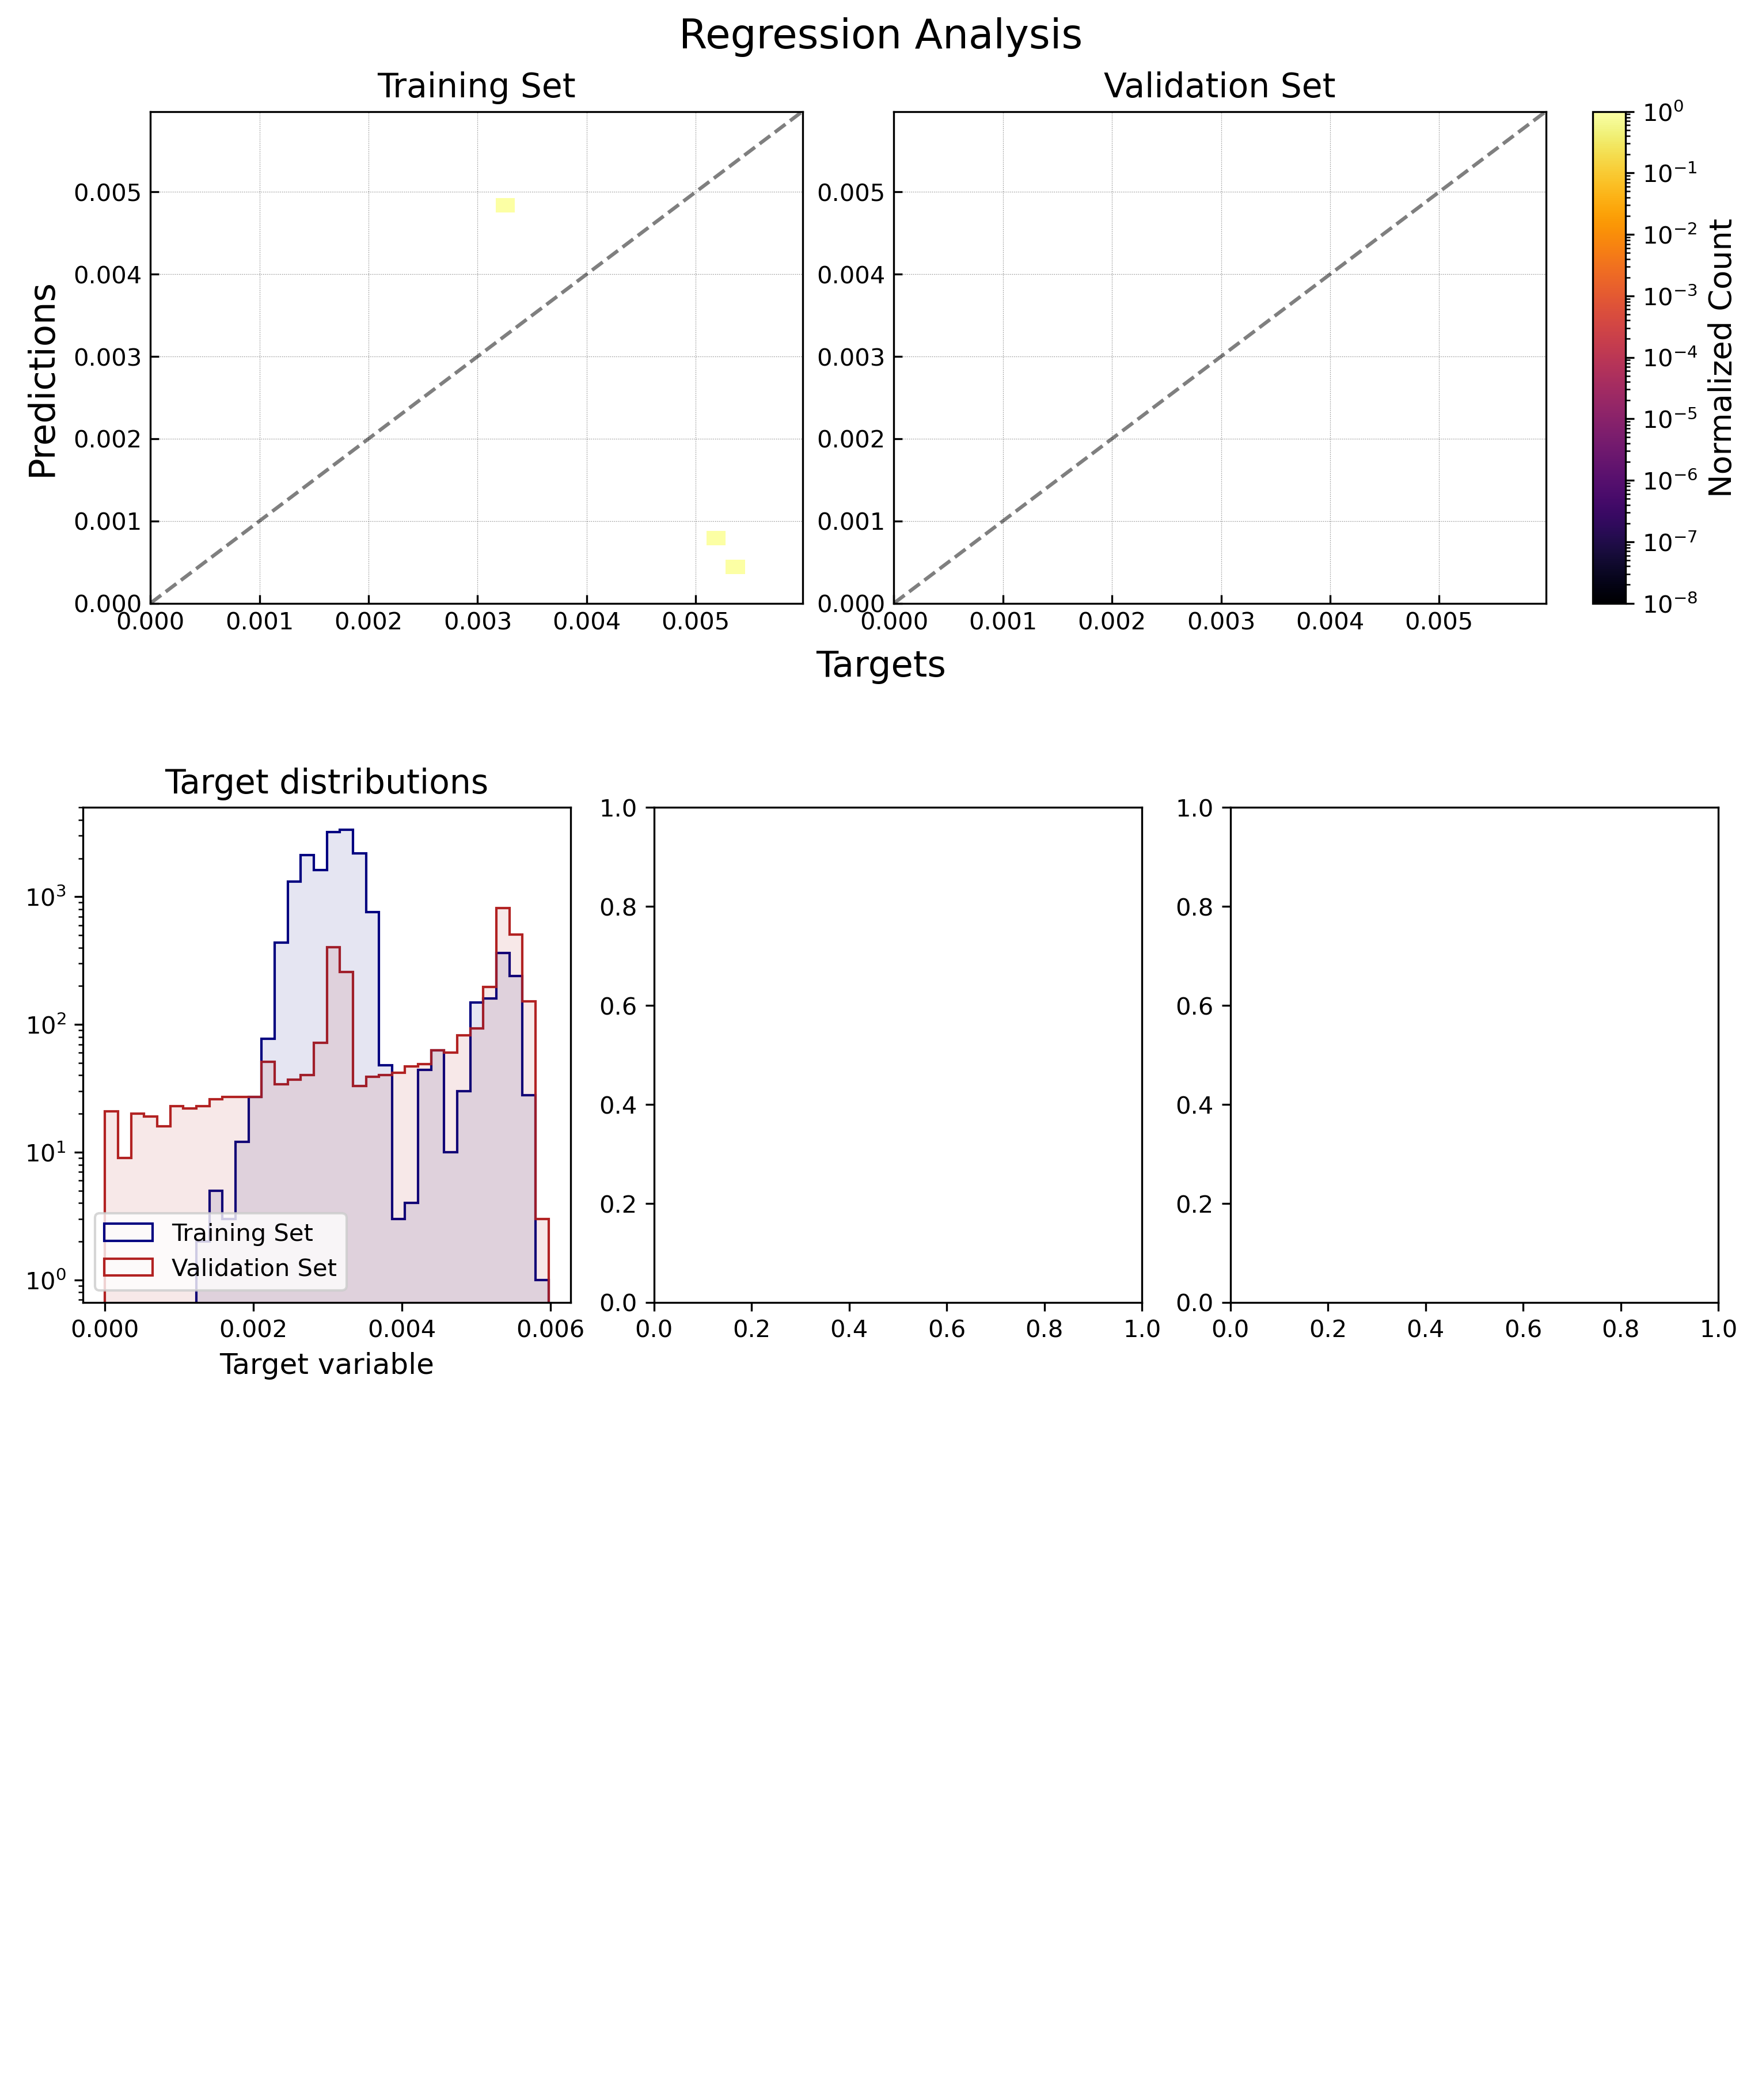

In [56]:
# Ensure train_targets and train_predictions have the same length
min_train_len = min(len(train_targets), len(train_predictions))
train_targets = train_targets[:min_train_len]
train_predictions = train_predictions[:min_train_len]

# Ensure eval_targets and eval_predictions have the same length
min_eval_len = min(len(eval_targets), len(eval_predictions))
eval_targets = eval_targets[:min_eval_len]
eval_predictions = eval_predictions[:min_eval_len]

# Display regression results
display_regression_results(train_targets, train_predictions, eval_targets, eval_predictions)

In [6]:
import torch

import torch.optim as optim

# Example training data (replace with your actual data)
x_train = torch.randn(100, 2)  # 100 samples, 2 features
y_train = torch.randn(100, 2)  # 100 samples, 2 targets

# Define optimizer
optimizer = optim.Adam(inn.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass through the model
    z, log_jac_det = inn(x_train)
    
    # Compute loss (example: mean squared error)
    loss = torch.mean((z - y_train)**2) - torch.mean(log_jac_det)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Print loss for every epoch
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 2.2782087326049805
Epoch 10, Loss: 2.1817004680633545
Epoch 20, Loss: 2.124504327774048
Epoch 30, Loss: 2.0684521198272705
Epoch 40, Loss: 2.0159525871276855
Epoch 50, Loss: 1.9660544395446777
Epoch 60, Loss: 1.904843807220459
Epoch 70, Loss: 1.8379909992218018
Epoch 80, Loss: 1.7765297889709473
Epoch 90, Loss: 1.7227007150650024


In [50]:

# Ensure x_test has the correct shape by padding with zeros to match 32 features
x_test_padded = torch.nn.functional.pad(x_test, (0, 32 - x_test.shape[1]))

# Example inference
z_test, log_jac_det_test = inn(x_test_padded)
print("Test output:", z_test)


Test output: tensor([[ -2.3020,  -1.2552,   4.1440,   3.9758,  -0.6883,   5.5697,  -0.1932,
           2.3576, -10.9654,  -0.9126,  -3.7241,  -3.4485, -13.6564,  -3.7509,
           4.7454,  10.2643, -10.5678,  12.7980,  -4.2171,  -1.9569,   2.8801,
           7.0504,  -6.3905,   1.5840,   7.4318,   4.2144,  -7.6119,   3.7406,
          -1.6805,   2.3270,   0.5139,   2.8123],
        [ -1.0902,  -0.7709,   2.6233,   3.8551,  -5.5485,   4.8434,  -1.6784,
          -2.2014,  -9.0400,   1.3339,  -3.4467,  -5.6440, -13.2238,  -6.9626,
           7.4595,   9.9692,  -7.3366,  15.0771,  -1.5499,  -2.2887,   3.3657,
           8.0975,  -1.4572,   1.1110,   8.1832,   6.0042,  -9.0146,   2.9152,
          -2.2593,   2.3091,  -0.8606,   4.3370],
        [ -2.4670,  -2.0340,   4.0833,   4.1892,   1.0774,   2.7325,  -0.8623,
           0.5283, -10.0644,   0.9015,  -2.2055,  -1.9569,  -9.6266,  -4.7092,
           5.3402,   7.2322,  -7.4216,  11.6369,  -2.0405,  -2.1720,   2.1271,
           6.1232,